In [1]:
import paths
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from spectroscopy.fies_utils import normalize_continuum, slice_spectrum_data
from spectroscopy.spectral_features import CaII_EMISSION_BANDS, get_triangular_function
from spectroscopy.spectrum_loader import SpectrumLoader, Spectrum

_w_min = 3875
_w_max = 4025
_degrees = {"V834Tau": 2, "V383Lac": 2}
_iterations = {"V834Tau": 3, "V383Lac": 5}
    
_loader = SpectrumLoader(paths.FITS_DATA_FOLDER, paths.OBSERVATIONS_FILE)
_star_data = pd.read_csv(paths.STAR_DATA, index_col="name")["b_v"]
_corrected_from_pipeline = dict(np.load(paths.VRAD_CORRECTED_FILE))
print(_loader.target_list)

['BECet', 'EXCet', 'HNPeg', 'V383Lac', 'V453And', 'V774Tau', 'V834Tau', 'V889Her']


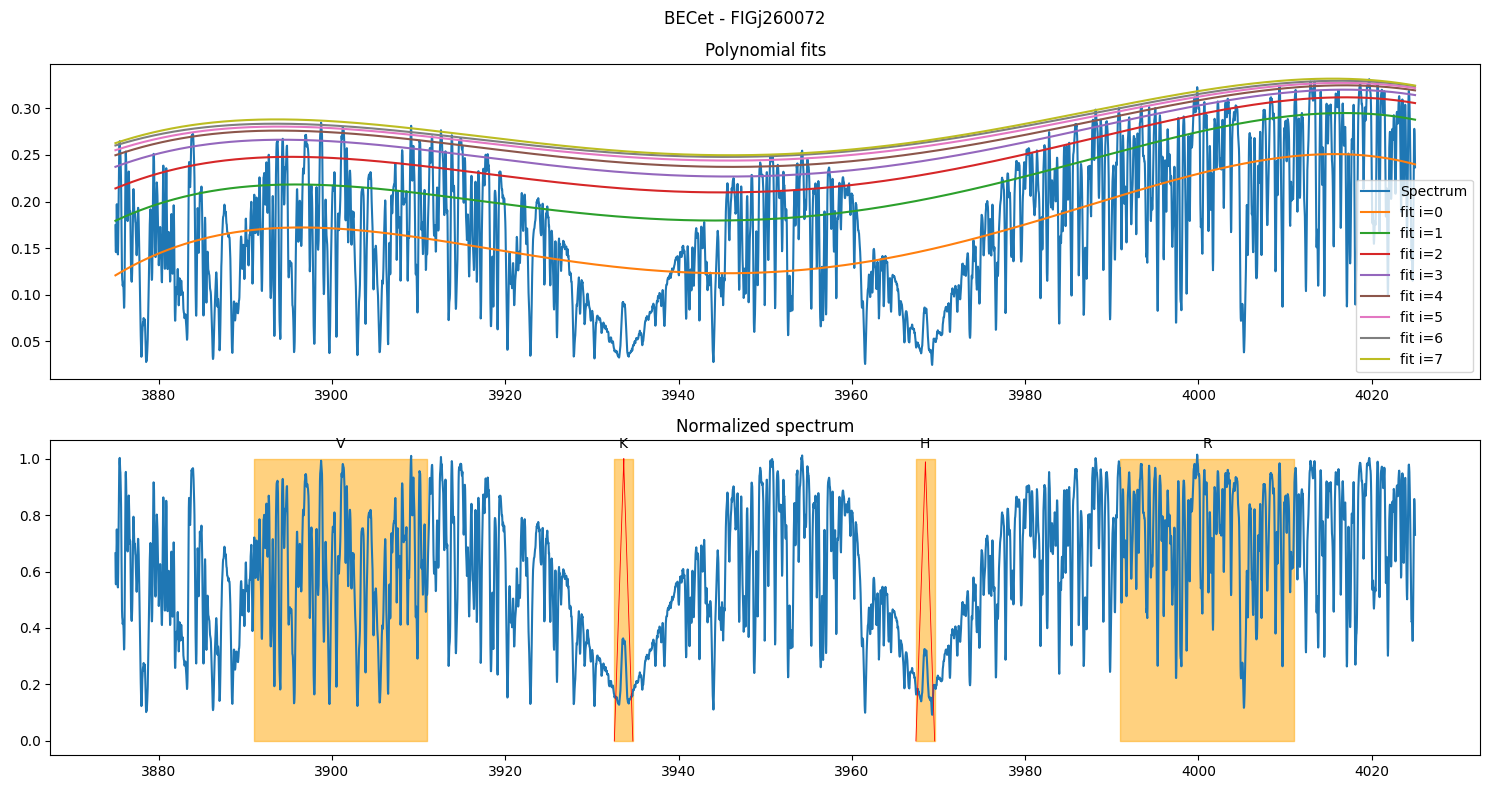

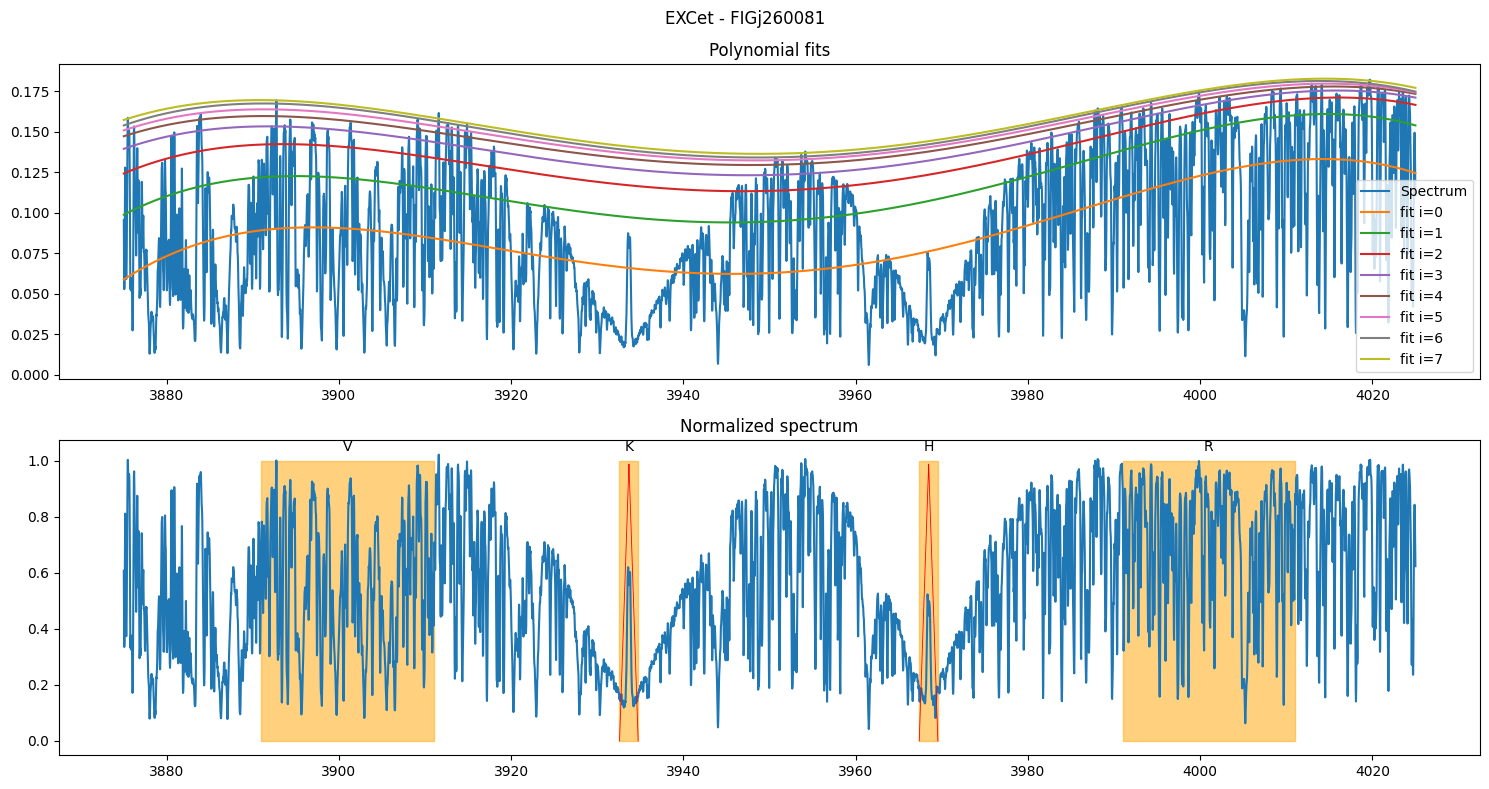

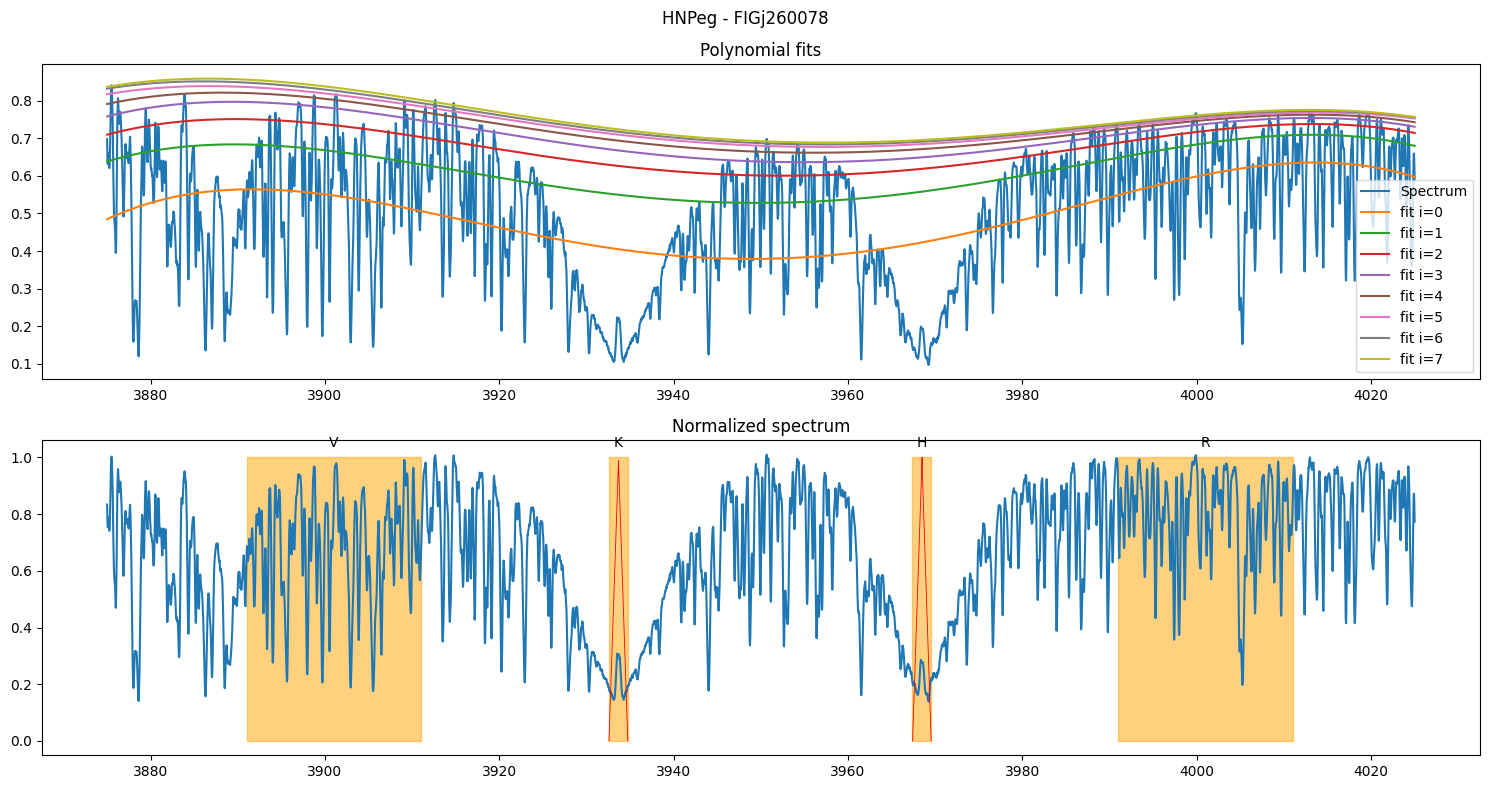

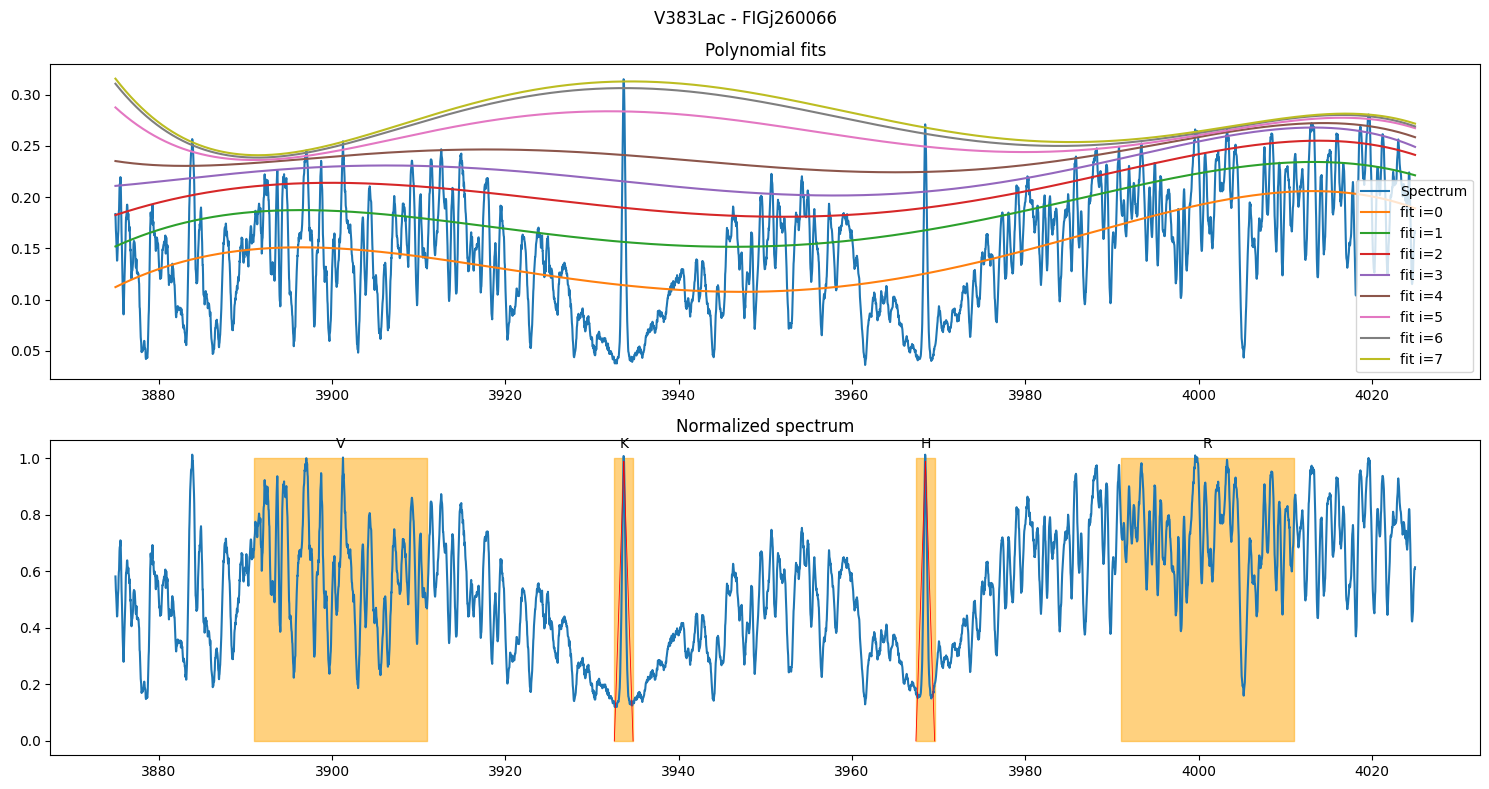

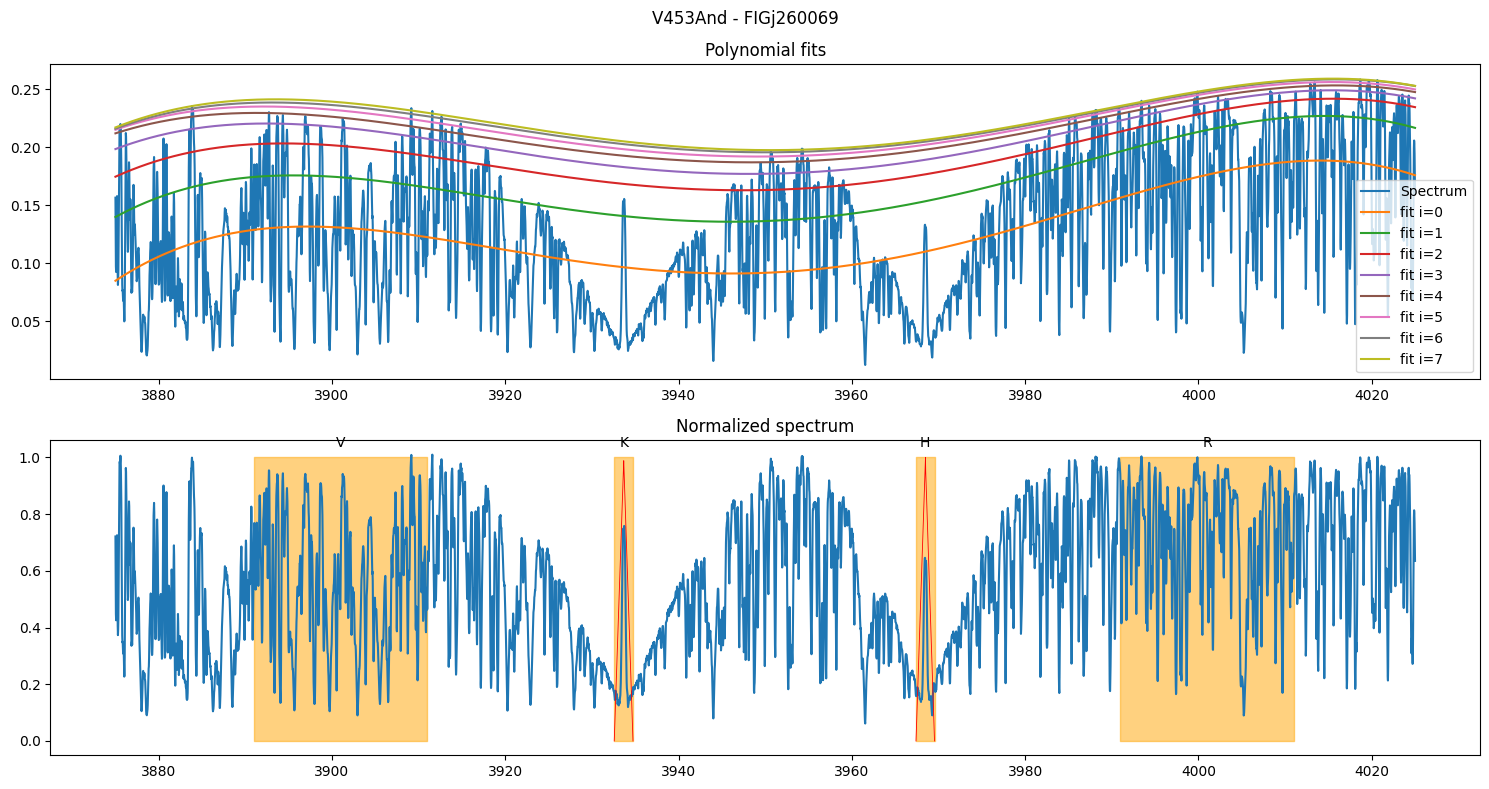

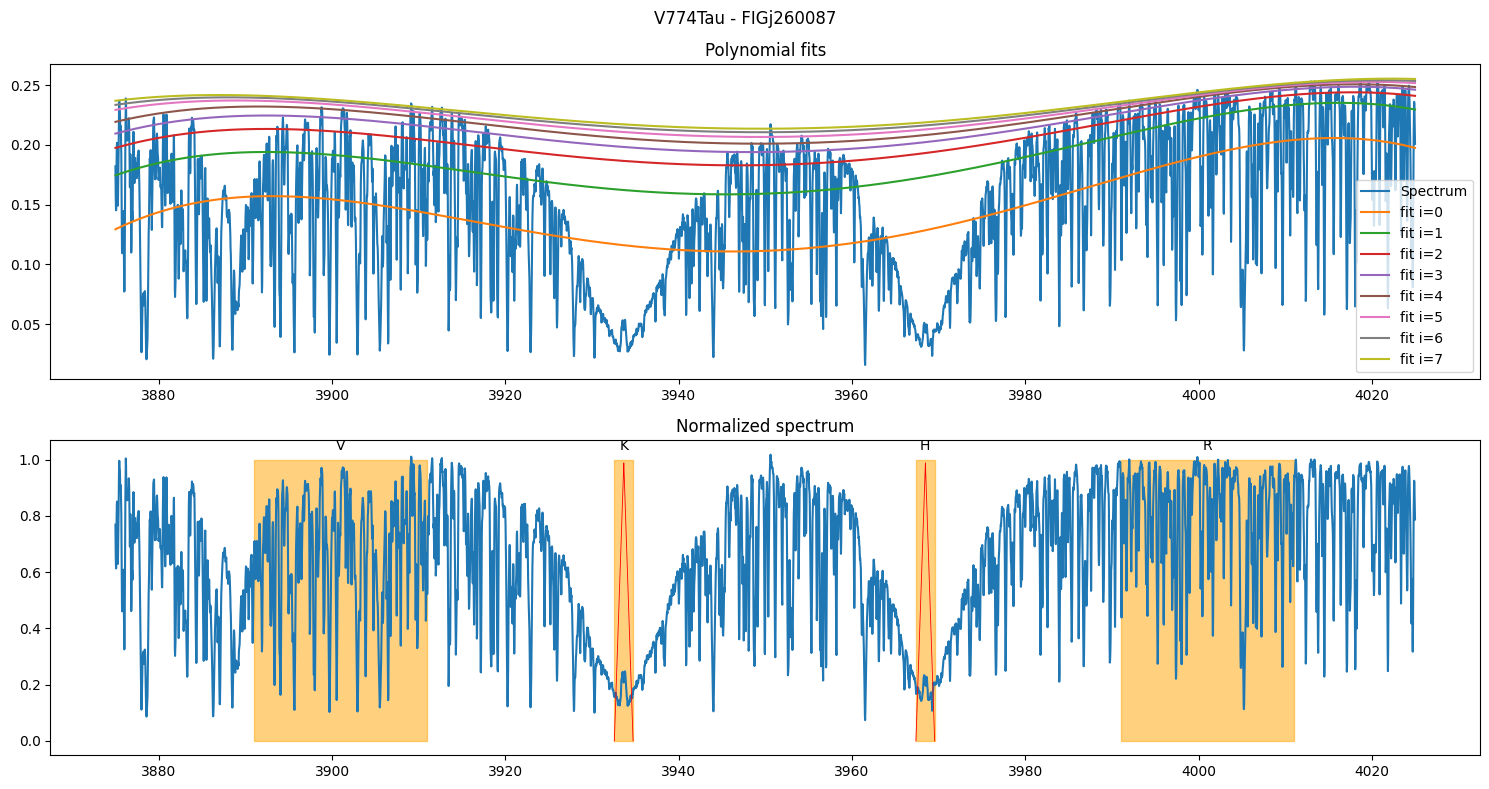

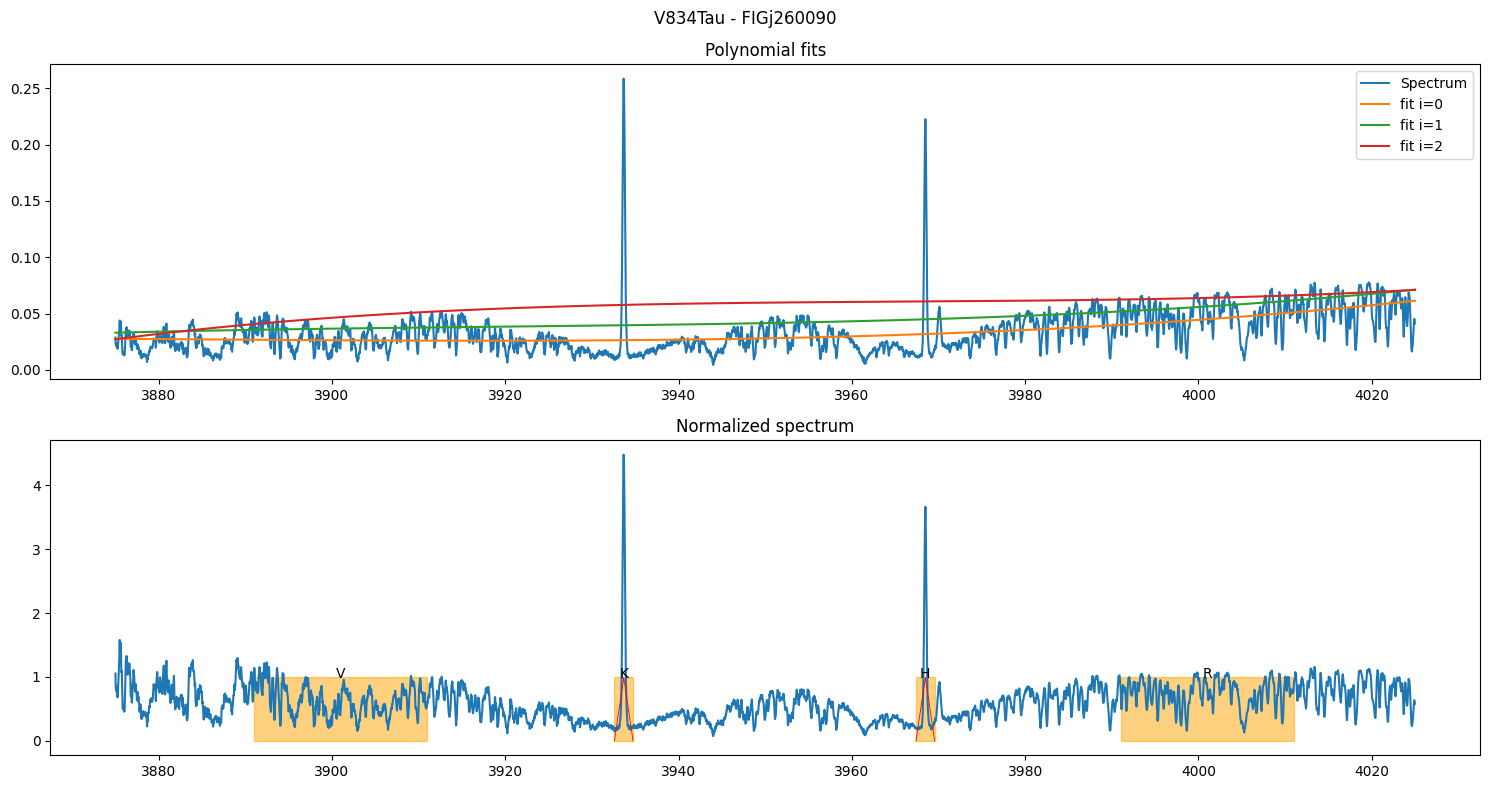

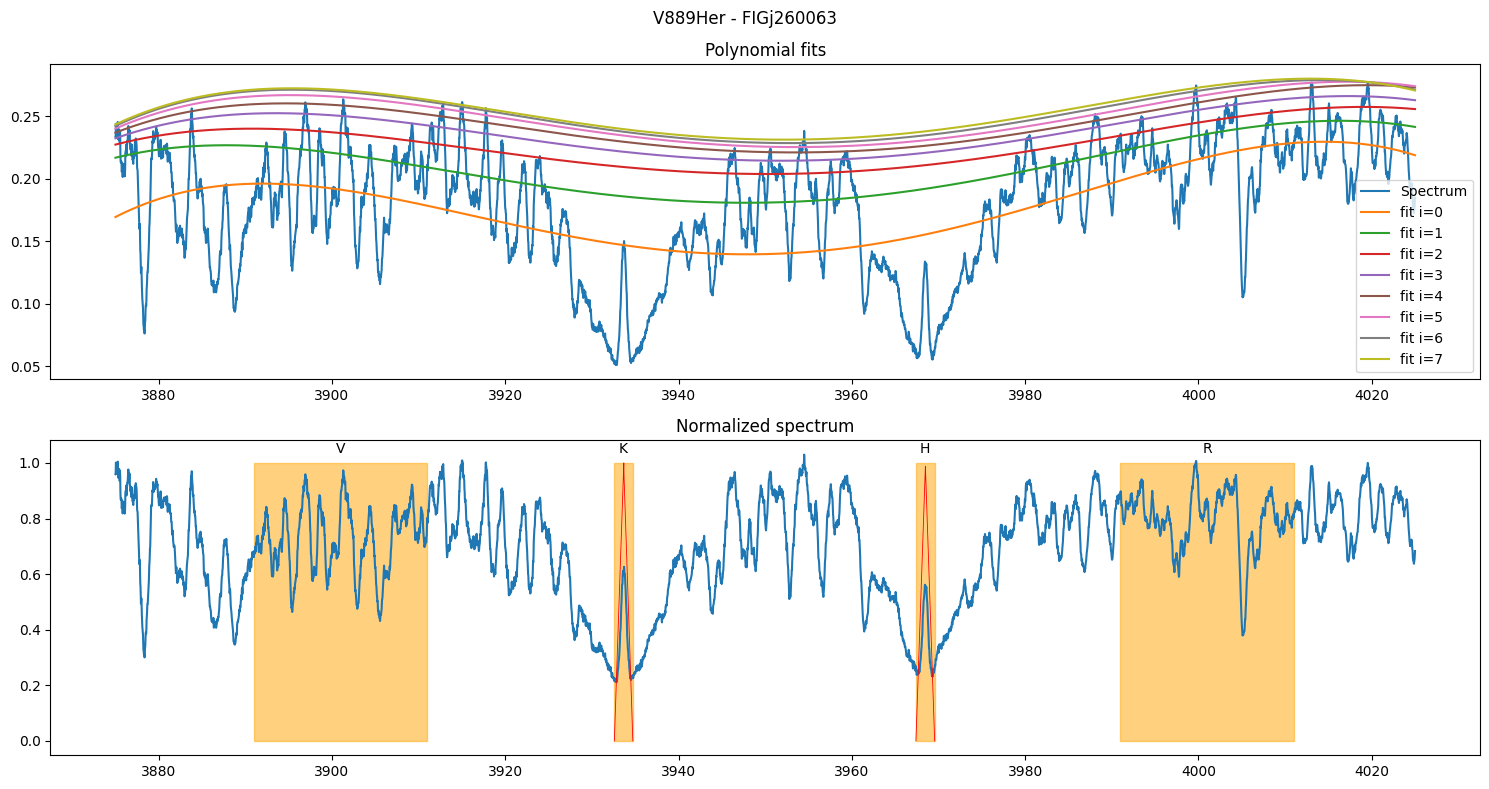

In [2]:
def plot_bands(data: np.ndarray, ax: plt.Axes):
    ax.plot(data[:, 0], data[:, 1])
    for line in ["V", "K", "H", "R"]:
        (x1, x2) = CaII_EMISSION_BANDS[line]
        ax.fill_betweenx([0, 1], x1, x2, color="orange", alpha=0.5)
        ax.text((x1 + x2) / 2, 1.05, line, horizontalalignment='center', verticalalignment='center')
        if line in ["H", "K"]:
            xi = (x1 <= data[:, 0]) & (data[:, 0] <= x2)
            tri = get_triangular_function(np.sum(xi))
            ax.plot(data[xi, 0], tri, color="red", linewidth=0.6)
        
    
def plot_normalization(spectrum: Spectrum, degrees: int, iterations: int):
    data = spectrum.data
    normalized_data, fits = normalize_continuum(data, degrees, iterations)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
    
    ax1.plot(data[:, 0], data[:, 1], label="Spectrum")
    for i in range(fits.shape[0]):
        ax1.plot(normalized_data[:, 0], fits[i, :], label=f"fit i={i}")
    
    plot_bands(normalized_data, ax2)
    ax1.set(title="Polynomial fits")
    ax2.set(title="Normalized spectrum")
    
    plt.suptitle(f"{spectrum.target_name} - {spectrum.id}")
    ax1.legend()
    plt.tight_layout()
    plt.show()

_default = {"degrees": 4, "iterations": 8}
_settings = {
    "V834Tau": {"degrees": 3, "iterations": 3},
    "V383Lac": {"degrees": 5, "iterations":8}
}
for target, data in _corrected_from_pipeline.items():
    spec = _loader.get_spectra(target)[0]
    spec.data = slice_spectrum_data(data, _w_min, _w_max) 
    plot_normalization(
        spectrum=spec, 
        **_settings.get(target, _default))
